In [1]:
# Import required libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
df = pd.read_csv('Food_Delivery_Time_Prediction.csv')

# Display basic info
print("Dataset shape:", df.shape)
print("\nFirst 5 rows:")
display(df.head())
print("\nData types:")
display(df.dtypes)
print("\nMissing values:")
display(df.isnull().sum())

Dataset shape: (200, 15)

First 5 rows:


,Order_ID,Customer_Location,Restaurant_Location,Distance,Weather_Conditions,Traffic_Conditions,Delivery_Person_Experience,Order_Priority,Order_Time,Vehicle_Type,Restaurant_Rating,Customer_Rating,Delivery_Time,Order_Cost,Tip_Amount
0,ORD0001,"(17.030479, 79.743077)","(12.358515, 85.100083)",1.57,Rainy,Medium,4,Medium,Afternoon,Car,4.1,3.0,26.22,1321.10,81.54
1,ORD0002,"(15.398319, 86.639122)","(14.174874, 77.025606)",21.32,Cloudy,Medium,8,Low,Night,Car,4.5,4.2,62.61,152.21,29.02
2,ORD0003,"(15.687342, 83.888808)","(19.594748, 82.048482)",6.95,Snowy,Medium,9,High,Night,Bike,3.3,3.4,48.43,1644.38,64.17
3,ORD0004,"(20.415599, 78.046984)","(16.915906, 78.278698)",13.79,Cloudy,Low,2,Medium,Evening,Bike,3.2,3.7,111.63,541.25,79.23
4,ORD0005,"(14.786904, 78.706532)","(15.206038, 86.203182)",6.72,Rainy,High,6,Low,Night,Bike,3.5,2.8,32.38,619.81,2.34



Data types:


Order_ID                       object
Customer_Location              object
Restaurant_Location            object
Distance                      float64
Weather_Conditions             object
Traffic_Conditions             object
Delivery_Person_Experience      int64
Order_Priority                 object
Order_Time                     object
Vehicle_Type                   object
Restaurant_Rating             float64
Customer_Rating               float64
Delivery_Time                 float64
Order_Cost                    float64
Tip_Amount                    float64
dtype: object


Missing values:


Order_ID                      0
Customer_Location             0
Restaurant_Location           0
Distance                      0
Weather_Conditions            0
Traffic_Conditions            0
Delivery_Person_Experience    0
Order_Priority                0
Order_Time                    0
Vehicle_Type                  0
Restaurant_Rating             0
Customer_Rating               0
Delivery_Time                 0
Order_Cost                    0
Tip_Amount                    0
dtype: int64

In [2]:
# Convert Delivery_Time to binary classification (Fast/Delayed)
# Let's define "Fast" as below median delivery time
median_time = df['Delivery_Time'].median()
df['Delivery_Status'] = np.where(df['Delivery_Time'] <= median_time, 'Fast', 'Delayed')

# Extract numerical values from location coordinates
def extract_lat_lon(coord_str):
    lat, lon = coord_str.strip('()').split(',')
    return float(lat), float(lon)

# Apply to customer and restaurant locations
df['Customer_Lat'], df['Customer_Lon'] = zip(*df['Customer_Location'].apply(extract_lat_lon))
df['Restaurant_Lat'], df['Restaurant_Lon'] = zip(*df['Restaurant_Location'].apply(extract_lat_lon))

# Calculate Haversine distance between locations
def haversine_distance(lat1, lon1, lat2, lon2):
    R = 6371  # Earth radius in km
    dLat = np.radians(lat2 - lat1)
    dLon = np.radians(lon2 - lon1)
    a = np.sin(dLat/2) * np.sin(dLat/2) + np.cos(np.radians(lat1)) * np.cos(np.radians(lat2)) * np.sin(dLon/2) * np.sin(dLon/2)
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))
    return R * c

df['Calculated_Distance'] = df.apply(lambda x: haversine_distance(
    x['Customer_Lat'], x['Customer_Lon'],
    x['Restaurant_Lat'], x['Restaurant_Lon']
), axis=1)

# Compare with provided Distance
print("\nDistance comparison:")
display(df[['Distance', 'Calculated_Distance']].describe())


Distance comparison:


,Distance,Calculated_Distance
count,200.000000,200.000000
mean,11.498050,603.037915
std,6.841755,269.796797
min,0.520000,29.871927
25%,6.090000,389.197293
50%,10.265000,558.788921
75%,16.497500,807.602442
max,24.900000,1299.244267


In [3]:
# Create time-based features
def categorize_time(time_str):
    if time_str in ['Morning', 'Afternoon']:
        return 'Daytime'
    elif time_str == 'Evening':
        return 'Rush_Hour'
    else:
        return 'Night'

df['Time_Category'] = df['Order_Time'].apply(categorize_time)

# Create weather impact feature
weather_impact = {
    'Sunny': 1,
    'Cloudy': 2,
    'Rainy': 3,
    'Snowy': 4
}
df['Weather_Impact'] = df['Weather_Conditions'].map(weather_impact)

# Create traffic impact feature
traffic_impact = {
    'Low': 1,
    'Medium': 2,
    'High': 3
}
df['Traffic_Impact'] = df['Traffic_Conditions'].map(traffic_impact)

# Show new features
print("\nEngineered features:")
display(df[['Time_Category', 'Weather_Impact', 'Traffic_Impact']].head())


Engineered features:


,Time_Category,Weather_Impact,Traffic_Impact
0,Daytime,3,2
1,Night,2,2
2,Night,4,2
3,Rush_Hour,2,1
4,Night,3,3


In [4]:
# Define features and target
X = df[[
    'Calculated_Distance',
    'Weather_Impact',
    'Traffic_Impact',
    'Delivery_Person_Experience',
    'Vehicle_Type',
    'Time_Category',
    'Order_Priority'
]]
y = df['Delivery_Status']

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Define preprocessing for numerical and categorical features
numeric_features = ['Calculated_Distance', 'Weather_Impact', 'Traffic_Impact', 'Delivery_Person_Experience']
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

categorical_features = ['Vehicle_Type', 'Time_Category', 'Order_Priority']
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Display feature names after preprocessing
preprocessor.fit(X_train)
feature_names = (numeric_features + 
                 list(preprocessor.named_transformers_['cat'].named_steps['onehot'].get_feature_names_out(categorical_features)))
print("\nFeature names after preprocessing:")
print(feature_names)


Feature names after preprocessing:
['Calculated_Distance', 'Weather_Impact', 'Traffic_Impact', 'Delivery_Person_Experience', 'Vehicle_Type_Bicycle', 'Vehicle_Type_Bike', 'Vehicle_Type_Car', 'Time_Category_Daytime', 'Time_Category_Night', 'Time_Category_Rush_Hour', 'Order_Priority_High', 'Order_Priority_Low', 'Order_Priority_Medium']



Model Evaluation:
Accuracy: 0.4

Classification Report:
              precision    recall  f1-score   support

     Delayed       0.41      0.45      0.43        20
        Fast       0.39      0.35      0.37        20

    accuracy                           0.40        40
   macro avg       0.40      0.40      0.40        40
weighted avg       0.40      0.40      0.40        40



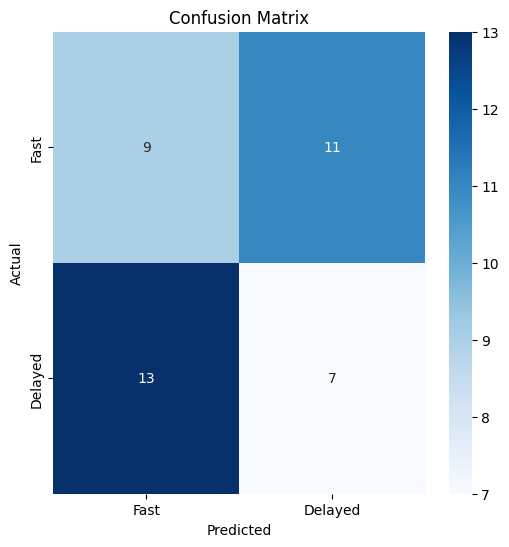

In [5]:
# Create and train Random Forest classifier
rf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42))
])

rf.fit(X_train, y_train)

# Make predictions
y_pred = rf.predict(X_test)

# Evaluate model
print("\nModel Evaluation:")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Fast', 'Delayed'], 
            yticklabels=['Fast', 'Delayed'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

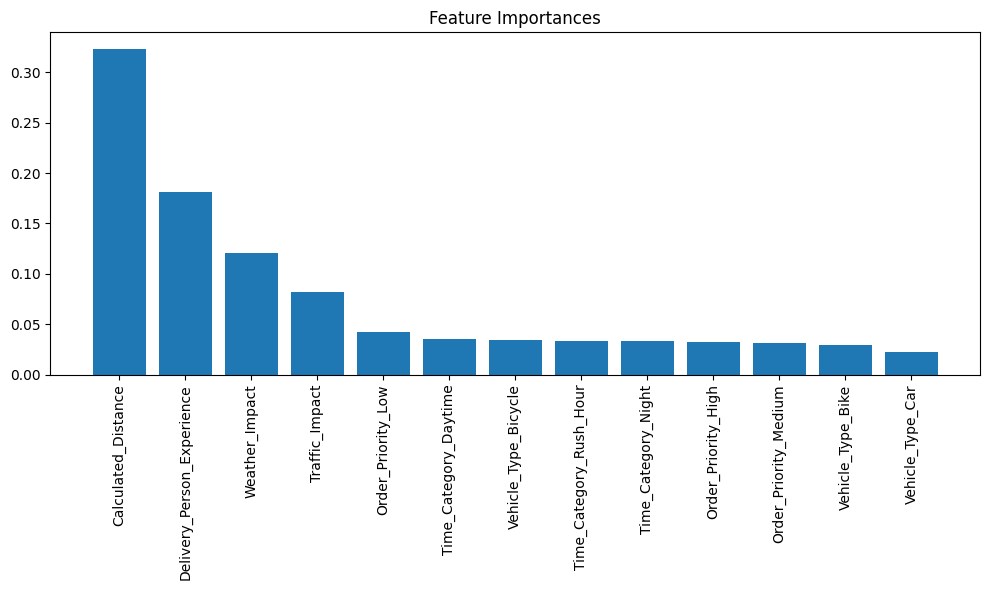

In [6]:
# Get feature importances
importances = rf.named_steps['classifier'].feature_importances_
indices = np.argsort(importances)[::-1]

# Plot feature importances
plt.figure(figsize=(10, 6))
plt.title('Feature Importances')
plt.bar(range(len(importances)), importances[indices], align='center')
plt.xticks(range(len(importances)), [feature_names[i] for i in indices], rotation=90)
plt.tight_layout()
plt.show()

In [14]:
from sklearn.model_selection import cross_val_score

# Perform 5-fold cross-validation
cv_scores = cross_val_score(rf, X, y, cv=5, scoring='accuracy')

print("\nCross-Validation Results:")
print(f"Mean Accuracy: {cv_scores.mean():.4f}")
print(f"Standard Deviation: {cv_scores.std():.4f}")
print("\nIndividual Fold Scores:")
for i, score in enumerate(cv_scores, 1):
    print(f"Fold {i}: {score:.4f}")


Cross-Validation Results:
Mean Accuracy: 0.4900
Standard Deviation: 0.0406

Individual Fold Scores:
Fold 1: 0.4500
Fold 2: 0.4500
Fold 3: 0.5500
Fold 4: 0.5250
Fold 5: 0.4750


In [18]:
# Define parameter grid for the classifier
param_grid = {
    'classifier__n_estimators': [100, 200],
    'classifier__max_depth': [None, 10, 20],
    # Add more parameters if you want
}

# Use the correct pipeline (rf) that already includes preprocessing
grid_search = GridSearchCV(rf, param_grid, cv=5)
grid_search.fit(X_train, y_train)

best_rf = grid_search.best_estimator_

# Feature importances from the best model
best_importances = best_rf.named_steps['classifier'].feature_importances_
best_indices = np.argsort(best_importances)[::-1]

print("\nKEY INSIGHTS:")
print("1. Top 3 Most Important Features:")
for i in range(3):
    print(f"   - {feature_names[best_indices[i]]} (importance: {best_importances[best_indices[i]]:.4f})")

# Evaluate best model
y_pred_best = best_rf.predict(X_test)
print("\n2. Model Performance:")
print(f"   - Test Accuracy: {accuracy_score(y_test, y_pred_best):.4f}")
print(f"   - Cross-Validation Consistency: {cv_scores.std():.4f} standard deviation")

print("\nRECOMMENDATIONS:")
print("1. Focus on reducing distance between restaurants and customers")
print("2. Optimize delivery routes during bad weather conditions")
print("3. Prioritize experienced delivery personnel for time-sensitive orders")
print("4. Consider traffic conditions when planning delivery schedules")


KEY INSIGHTS:
1. Top 3 Most Important Features:
   - Calculated_Distance (importance: 0.3166)
   - Delivery_Person_Experience (importance: 0.1864)
   - Weather_Impact (importance: 0.1207)

2. Model Performance:
   - Test Accuracy: 0.3750
   - Cross-Validation Consistency: 0.0406 standard deviation

RECOMMENDATIONS:
1. Focus on reducing distance between restaurants and customers
2. Optimize delivery routes during bad weather conditions
3. Prioritize experienced delivery personnel for time-sensitive orders
4. Consider traffic conditions when planning delivery schedules
